In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
import absorption_line_vel as vel
from absorption_line_vel import SpectrumSN_Lines, AbsorbLine

# read spec data
spec = '../../spectroscopy/SN2020jgb/host_20220331_Keck2_corrected.ascii'
Spec1 = SpectrumSN_Lines(spec, 0.0309)
Spec = SpectrumSN_Lines(spec, 0)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.labelsize'] = '20'

Emission lines from http://astronomy.nmsu.edu/drewski/tableofemissionlines.html

# 20220331_Keck2

## H$\alpha$

<AxesSubplot:>

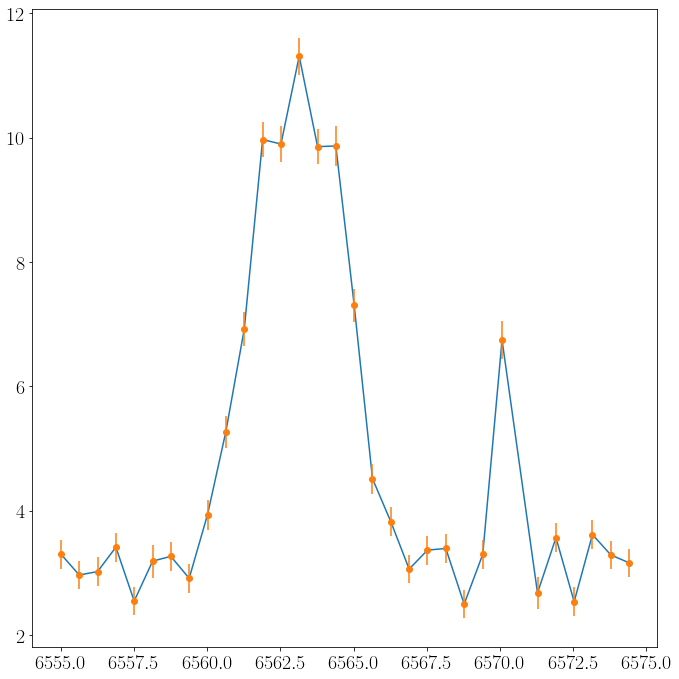

In [4]:
Spec1.plot_line_region(6555, 6575)

In [37]:
Spec1.add_line('Halpha', 6556, 6569.5, lines=[[6562.819]], rel_strength=[[]])
Spec1.line['Halpha'].LS_estimator(guess=(1, 1, 0, 10, 100))

LS estimation:
Velocity 1: 13 km/s


/Users/chang/Desktop/SNIa/SN2020jgb/rv/SN2020jgb/../absorption_line_vel.py:160: UserWarning: <=5 points within the wavelength range!
  warnings.warn(


Normalize factor = 1.765


 50%|█████     | 2500/5000 [00:07<00:07, 351.64it/s]


MCMC results:
Velocity 1: 13 pm 3 km/s


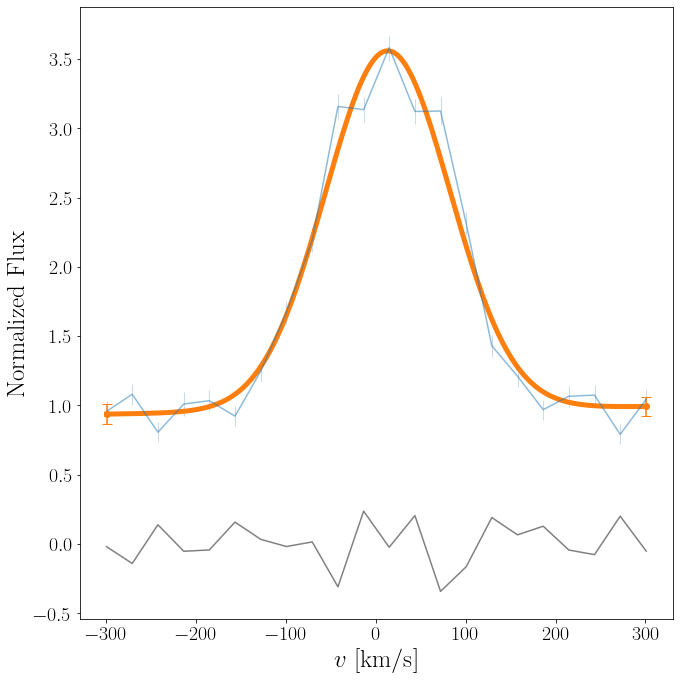

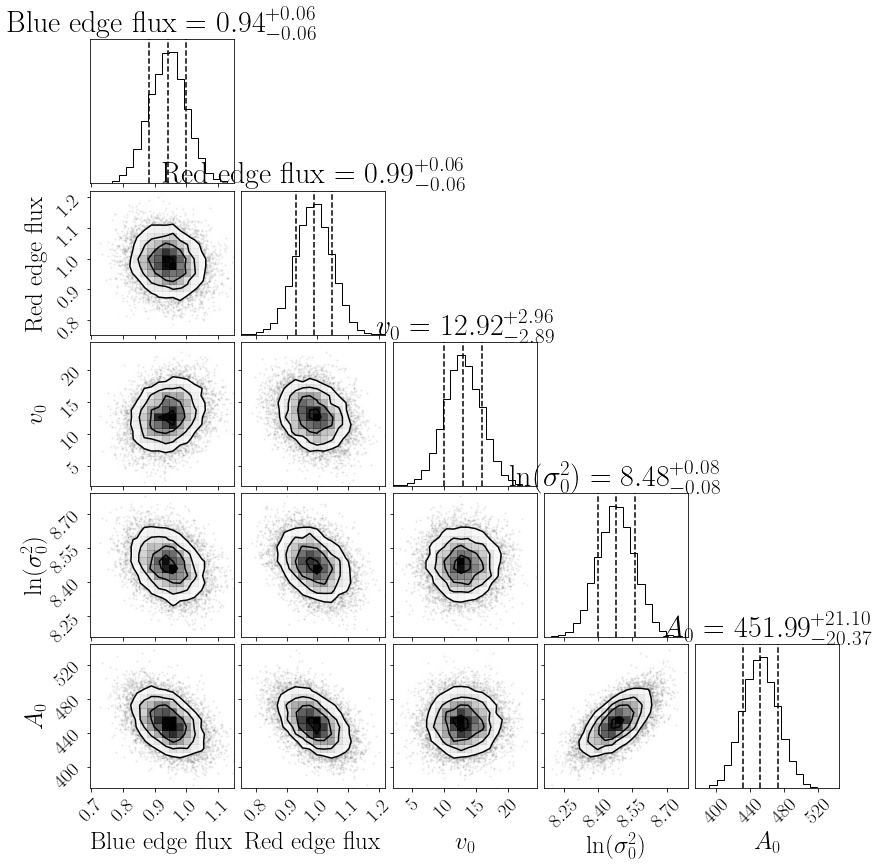

In [38]:
Spec1.line['Halpha'].MCMC_sampler(
    vel_flat=[-200, 200],
    var_max=5e4,
    initial=[],
    normalize_unc='LS',
    Plot_mcmc=True,
    max_nsteps=5000,
    Plot_tau=False)

In [39]:
Spec1.line['Halpha'].EW, Spec1.line['Halpha'].sig_EW

(-9.986973012678012, 0.4100294597703365)

## [N ii]

<AxesSubplot:>

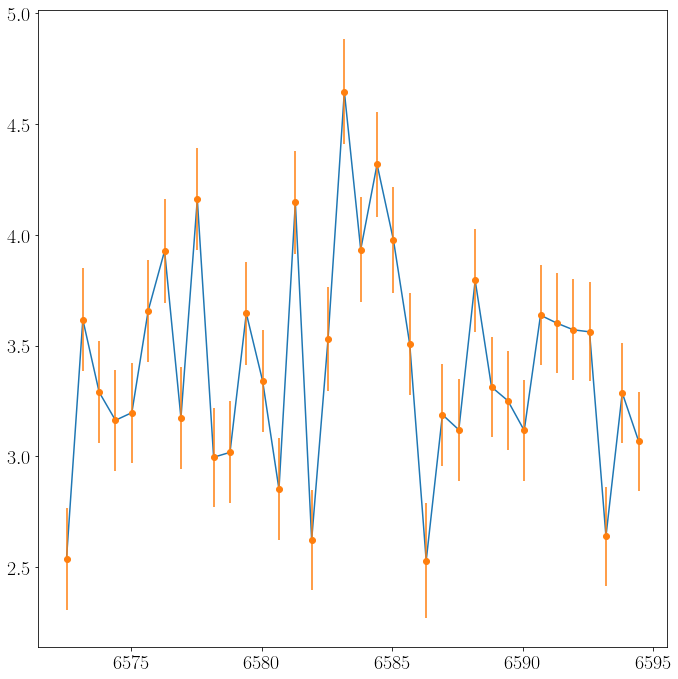

In [75]:
Spec1.plot_line_region(6572, 6595)

In [96]:
Spec1.add_line('Nii',
               6579,
               6587,
               lines=[[6583.460]],
               rel_strength=[[]])
Spec1.line['Nii'].LS_estimator(guess=(1, 1, 0, 8, 100))

LS estimation:
Velocity 1: 28 km/s


/Users/chang/Desktop/SNIa/SN2020jgb/rv/SN2020jgb/../absorption_line_vel.py:160: UserWarning: <=5 points within the wavelength range!
  warnings.warn(


Normalize factor = 1.870


100%|██████████| 5000/5000 [00:14<00:00, 345.93it/s]

MCMC results:
Velocity 1: 28 pm 16 km/s


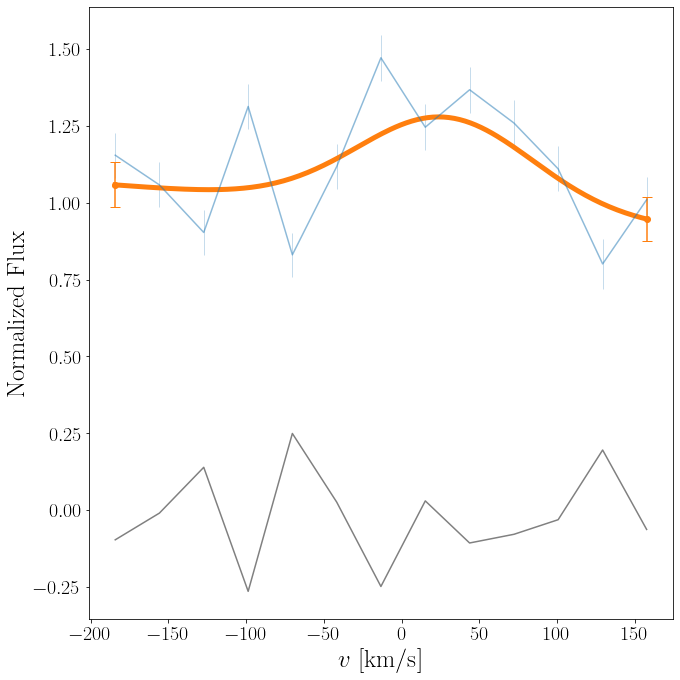

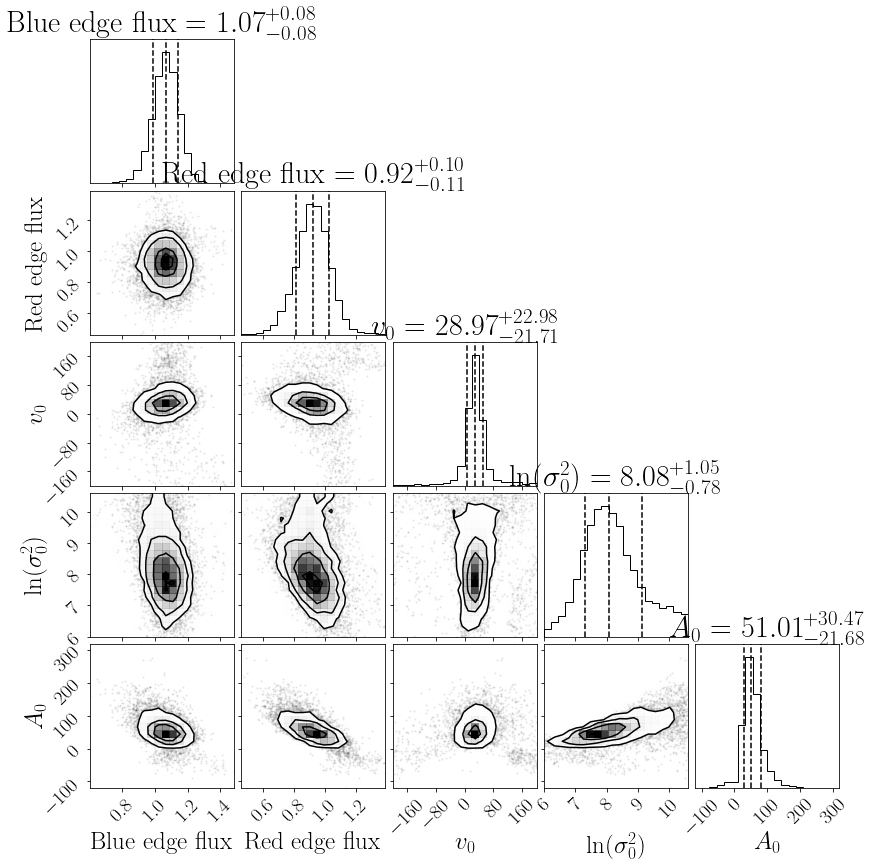

In [97]:
Spec1.line['Nii'].MCMC_sampler(
    vel_flat=[-200, 200],
    var_max=5e4,
    initial=[],
    normalize_unc='LS',
    Plot_mcmc=True,
    max_nsteps=5000,
    Plot_tau=False)

In [98]:
Spec1.line['Nii'].EW, Spec1.line['Nii'].sig_EW

(-0.8862505880319238, 0.3658105341477598)

In [99]:
result = Spec1.line['Nii'].EW / Spec1.line['Halpha'].EW
sig = ((Spec1.line['Nii'].sig_EW / Spec1.line['Nii'].EW)**2 +
       (Spec1.line['Halpha'].sig_EW / Spec1.line['Halpha'].EW)**2) * result
print('lg [Nii]/Halpha = {:.2f}+{:.2f}-{:.2f}'.format(
    np.log10(result), np.log10(1 + sig / result), -np.log10(1 - sig / result)))

lg [Nii]/Halpha = -1.05+0.07-0.08


## H$\beta$

<AxesSubplot:>

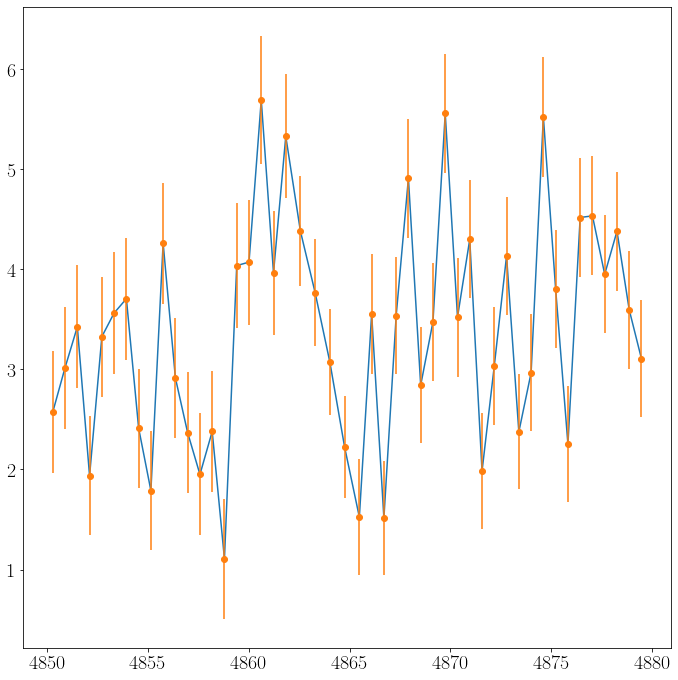

In [13]:
Spec1.plot_line_region(4850, 4880)

In [44]:
Spec1.add_line('Hbeta',
               4856,
               4867,
               lines=[[4861.333]],
               rel_strength=[[]])
Spec1.line['Hbeta'].LS_estimator(guess=(1, 1, 0, 8, 100))

LS estimation:
Velocity 1: 12 km/s


/Users/chang/Desktop/SNIa/SN2020jgb/rv/SN2020jgb/../absorption_line_vel.py:160: UserWarning: <=5 points within the wavelength range!
  warnings.warn(


Normalize factor = 1.221


 70%|███████   | 3500/5000 [00:09<00:04, 350.40it/s]


MCMC results:
Velocity 1: 8 pm 16 km/s


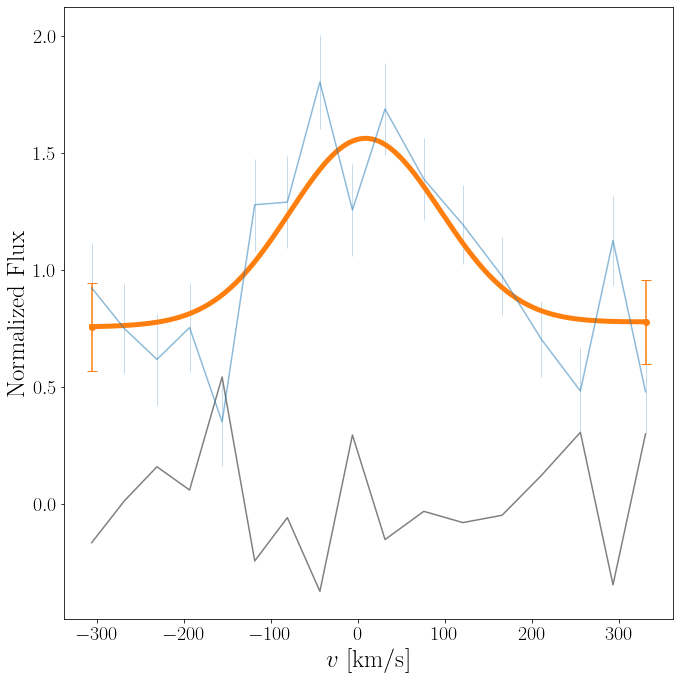

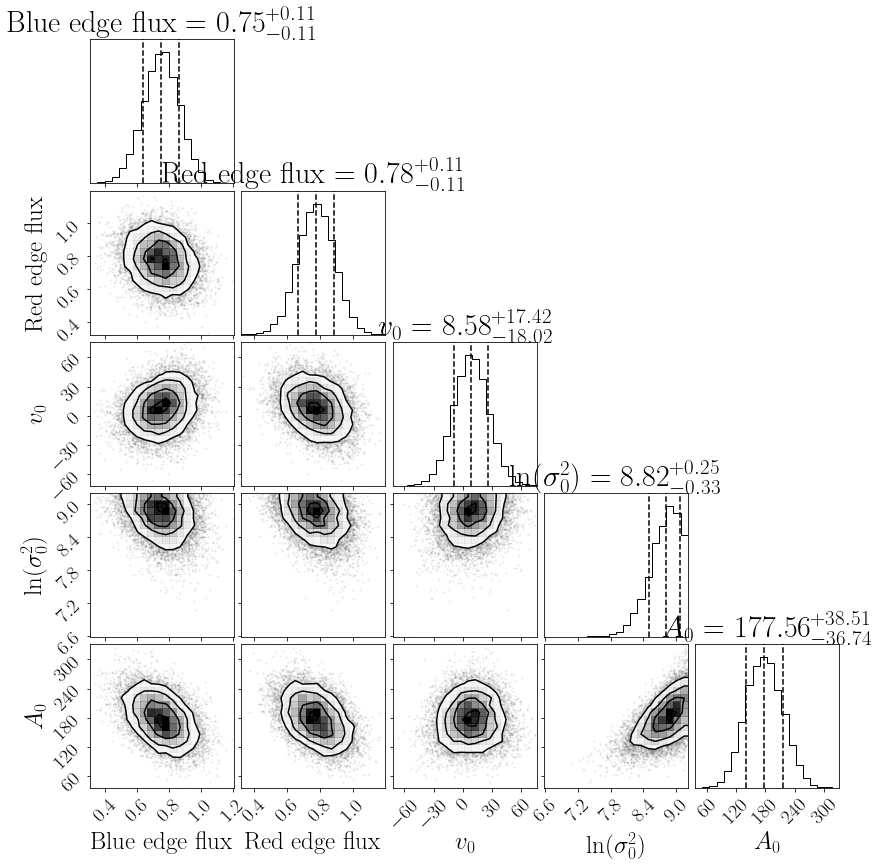

In [45]:
Spec1.line['Hbeta'].MCMC_sampler(
    vel_flat=[-100, 100],
    var_max=1e5,
    initial=[],
    normalize_unc='LS',
    Plot_mcmc=True,
    max_nsteps=5000,
    Plot_tau=False)

In [46]:
Spec1.line['Hbeta'].EW, Spec1.line['Hbeta'].sig_EW

(-3.433017942869835, 0.6605535452352411)

## [O iii]

<AxesSubplot:>

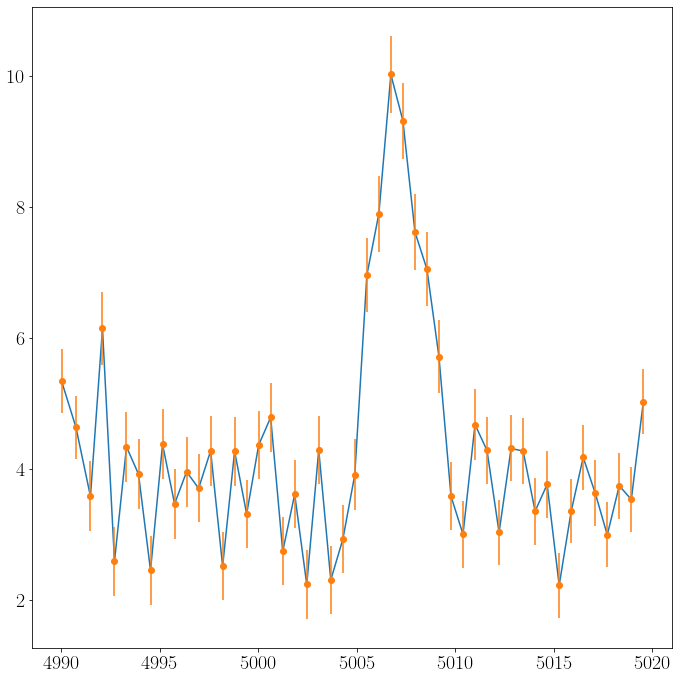

In [17]:
Spec1.plot_line_region(4990, 5020)

In [84]:
Spec1.add_line('Oiii',
               5003,
               5012,
               lines=[[5006.843]],
               rel_strength=[[]])
Spec1.line['Oiii'].LS_estimator(guess=(1, 1, 0, 8, 100))

LS estimation:
Velocity 1: 10 km/s


/Users/chang/Desktop/SNIa/SN2020jgb/rv/SN2020jgb/../absorption_line_vel.py:160: UserWarning: <=5 points within the wavelength range!
  warnings.warn(


Normalize factor = 1.326


 60%|██████    | 3000/5000 [00:08<00:05, 351.50it/s]


MCMC results:
Velocity 1: 11 pm 6 km/s


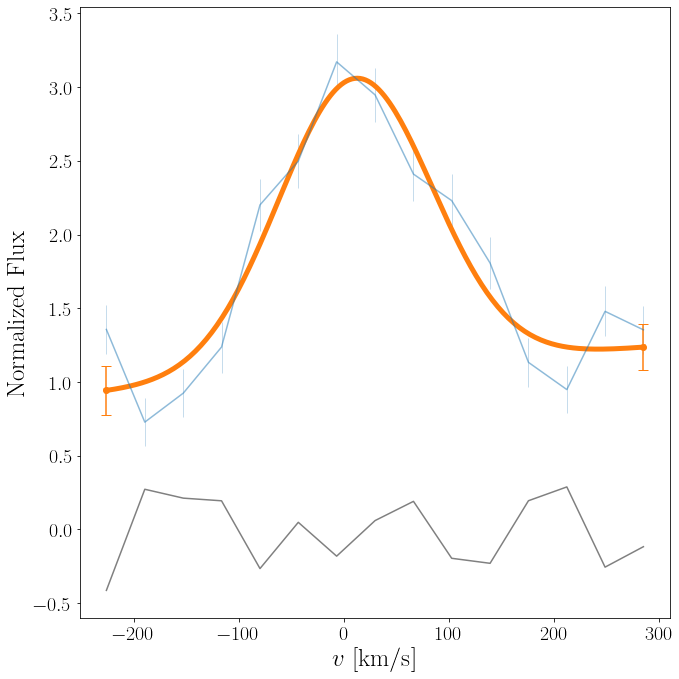

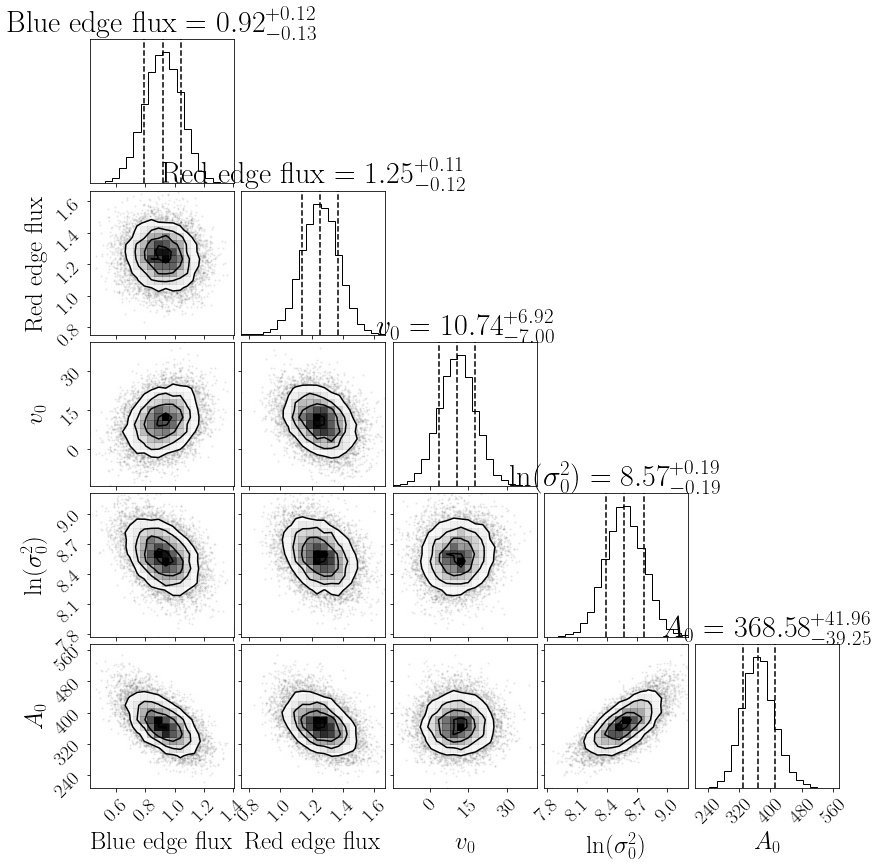

In [85]:
Spec1.line['Oiii'].MCMC_sampler(
    vel_flat=[-100, 100],
    var_max=1e5,
    initial=[],
    normalize_unc='LS',
    Plot_mcmc=True,
    max_nsteps=5000,
    Plot_tau=False)

In [86]:
Spec1.line['Oiii'].EW, Spec1.line['Oiii'].sig_EW

(-5.299951008781757, 0.5046097297400907)

In [87]:
result = Spec1.line['Oiii'].EW / Spec1.line['Hbeta'].EW
sig = ((Spec1.line['Oiii'].sig_EW / Spec1.line['Oiii'].EW)**2 +
       (Spec1.line['Hbeta'].sig_EW / Spec1.line['Hbeta'].EW)**2) * result
print('lg [Oiii]/Hbeta = {:.2f}+{:.2f}-{:.2f}'.format(
    np.log10(result), np.log10(1 + sig / result), -np.log10(1 - sig / result)))

lg [Oiii]/Hbeta = 0.19+0.02-0.02


## [S ii]

<AxesSubplot:>

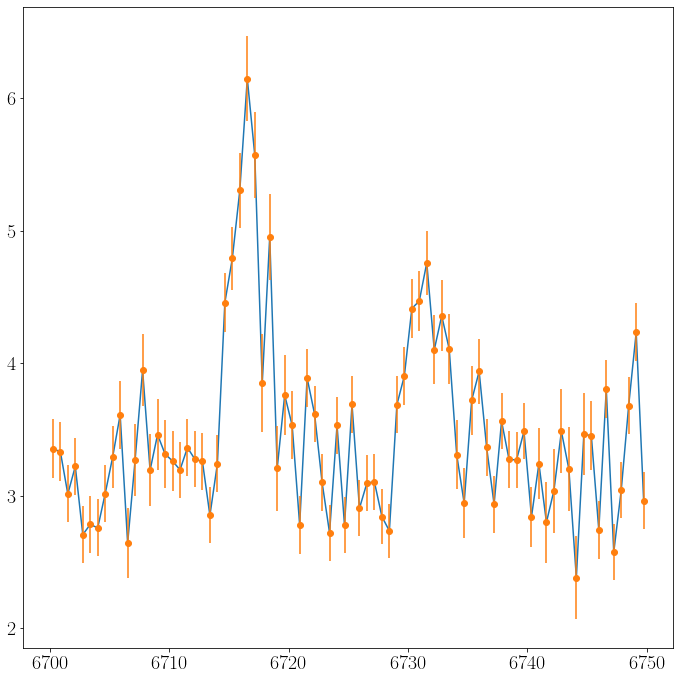

In [51]:
Spec1.plot_line_region(6700, 6750)

In [23]:
Spec1.add_line('Sii',
               6710,
               6740,
               lines=[[6716.440, 6730.810]],
               rel_strength=[[2, 1]])
Spec1.line['Sii'].LS_estimator(guess=(1, 1, 0, 8, 100))

LS estimation:
Velocity 1: 12 km/s


Normalize factor = 1.548


 18%|█▊        | 3500/20000 [00:12<00:58, 283.25it/s]

MCMC results:
Velocity 1: 13 pm 6 km/s


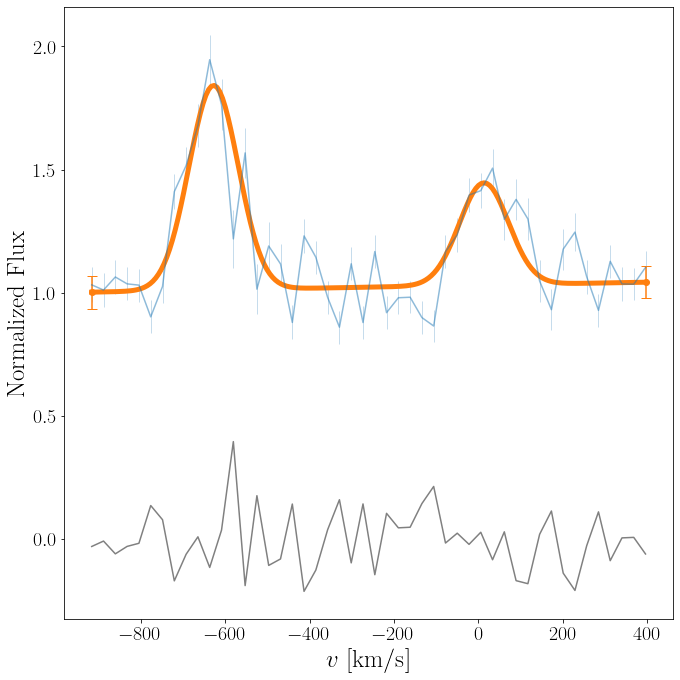

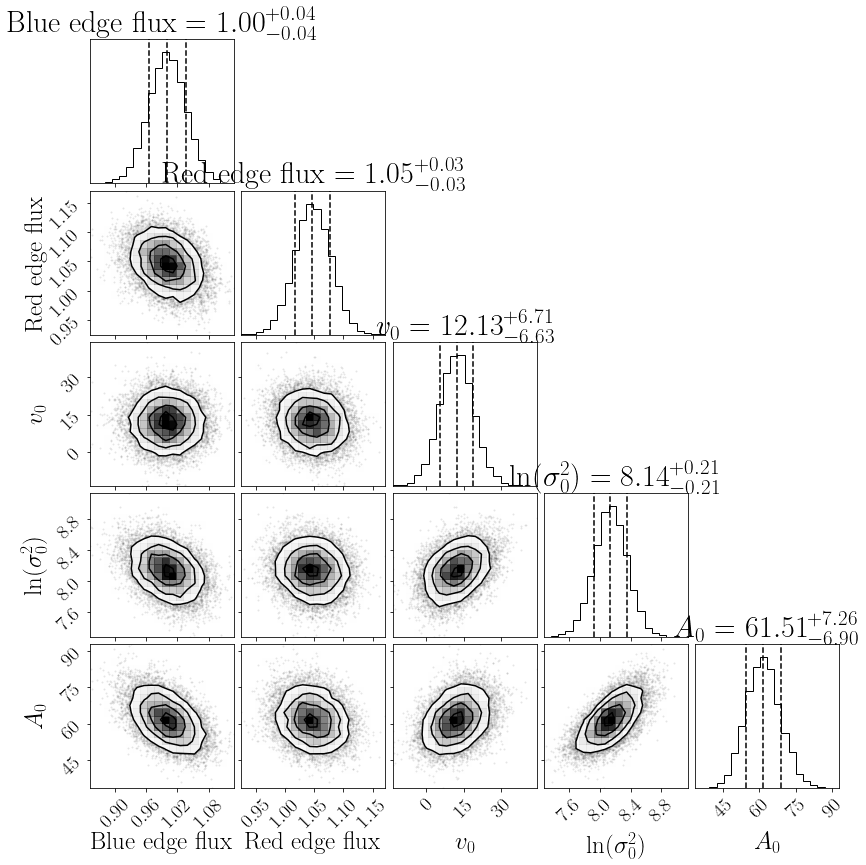

In [24]:
Spec1.line['Sii'].MCMC_sampler(
    vel_flat=[-100, 100],
    var_max=1e6,
    initial=[],
    normalize_unc='LS',
    Plot_mcmc=True,
    max_nsteps=5000,
    Plot_tau=False)

## Host extinction estimation

In [25]:
sys.path.append('../tools')
from dust_extinction import calALambda

In [100]:
Halpha_base = (Spec1.line['Halpha'].blue_fl[0] + Spec1.line['Halpha'].red_fl[0])
Halpha_flux = Spec1.line['Halpha'].EW * Halpha_base
Hbeta_base = (Spec1.line['Hbeta'].blue_fl[0] + Spec1.line['Hbeta'].red_fl[0])
Hbeta_flux = Spec1.line['Hbeta'].EW * Hbeta_base
result = Halpha_flux / Hbeta_flux
sig = ((Spec1.line['Halpha'].sig_EW / Spec1.line['Halpha'].EW)**2 +
       (Spec1.line['Hbeta'].sig_EW / Spec1.line['Hbeta'].EW)**2) * result
print('Halpha/Hbeta = {:.2f} +/- {:.2f}'.format(result, sig))


Halpha/Hbeta = 3.26 +/- 0.13


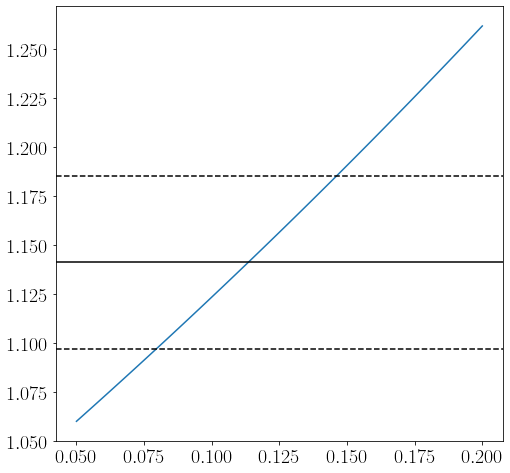

In [103]:
l_alpha, l_beta = 6562.819, 4861.333
R_V = 3.1
EBV = np.linspace(.05, .2, 100)
Av_alpha = calALambda(wv=l_alpha, RV=R_V, EBV=EBV)
Av_beta = calALambda(wv=l_beta, RV=R_V, EBV=EBV)
plt.figure(figsize=(8, 8))
plt.plot(EBV, 10**(-0.4 * (Av_alpha - Av_beta)))
plt.axhline(result / 2.86, color='k', linestyle='-')
plt.axhline((result + sig) / 2.86, color='k', linestyle='--')
plt.axhline((result - sig) / 2.86, color='k', linestyle='--')
plt.show()


In [30]:
leff_g = 4816.12  #AA
leff_r = 6234.11  #AA
rv = 3.1
ebv = 0.404
ebv_host = 0.15

A_g_host = calALambda(leff_g, rv, ebv_host)
A_r_host = calALambda(leff_r, rv, ebv_host)
A_g_host, A_r_host

(0.5492308903758504, 0.38125563044472854)